In [1]:
from intervals.main_rf import *
import re
import pandas as pd
from ipywidgets import interact

music21: Certain music21 functions might need the optional package matplotlib;
                  if you run into errors, install it by following the instructions at
                  http://mit.edu/music21/doc/installing/installAdditional.html


In [2]:
def map_colours(x, rest_colour="#fbb4ae", empty_colour="white", remainder_colour="#ccebc5"):
    if x == "Rest":
        return f"background: {rest_colour}"
    elif pd.isnull(x) or (not x) or (x == "-"):
        return f"background: {empty_colour}"
    else:
        return f"background: {remainder_colour}"
    
    
def add_offset(s, lyric_line=3):
    for n in s.recurse().getElementsByClass('Note'):
        n.addLyric(int(n.getOffsetBySite(s.flat.notes)), lyric_line)


# Select Piece

piece = 'https://raw.githubusercontent.com/RichardFreedman/CRIM_additional_works/main/MEI/CRIM_Cadences.mei'

In [3]:
piece = 'https://crimproject.org/mei/CRIM_Model_0009.mei'
# piece = 'https://raw.githubusercontent.com/RichardFreedman/CRIM_additional_works/main/MEI/CRIM_Model_0018_n2.mei_msg.mei'
corpus = CorpusBase([piece])

Successfully imported.


In [4]:
model = corpus.scores[0]

In [5]:
model.score.metadata.title

'Je suis déshéritée'

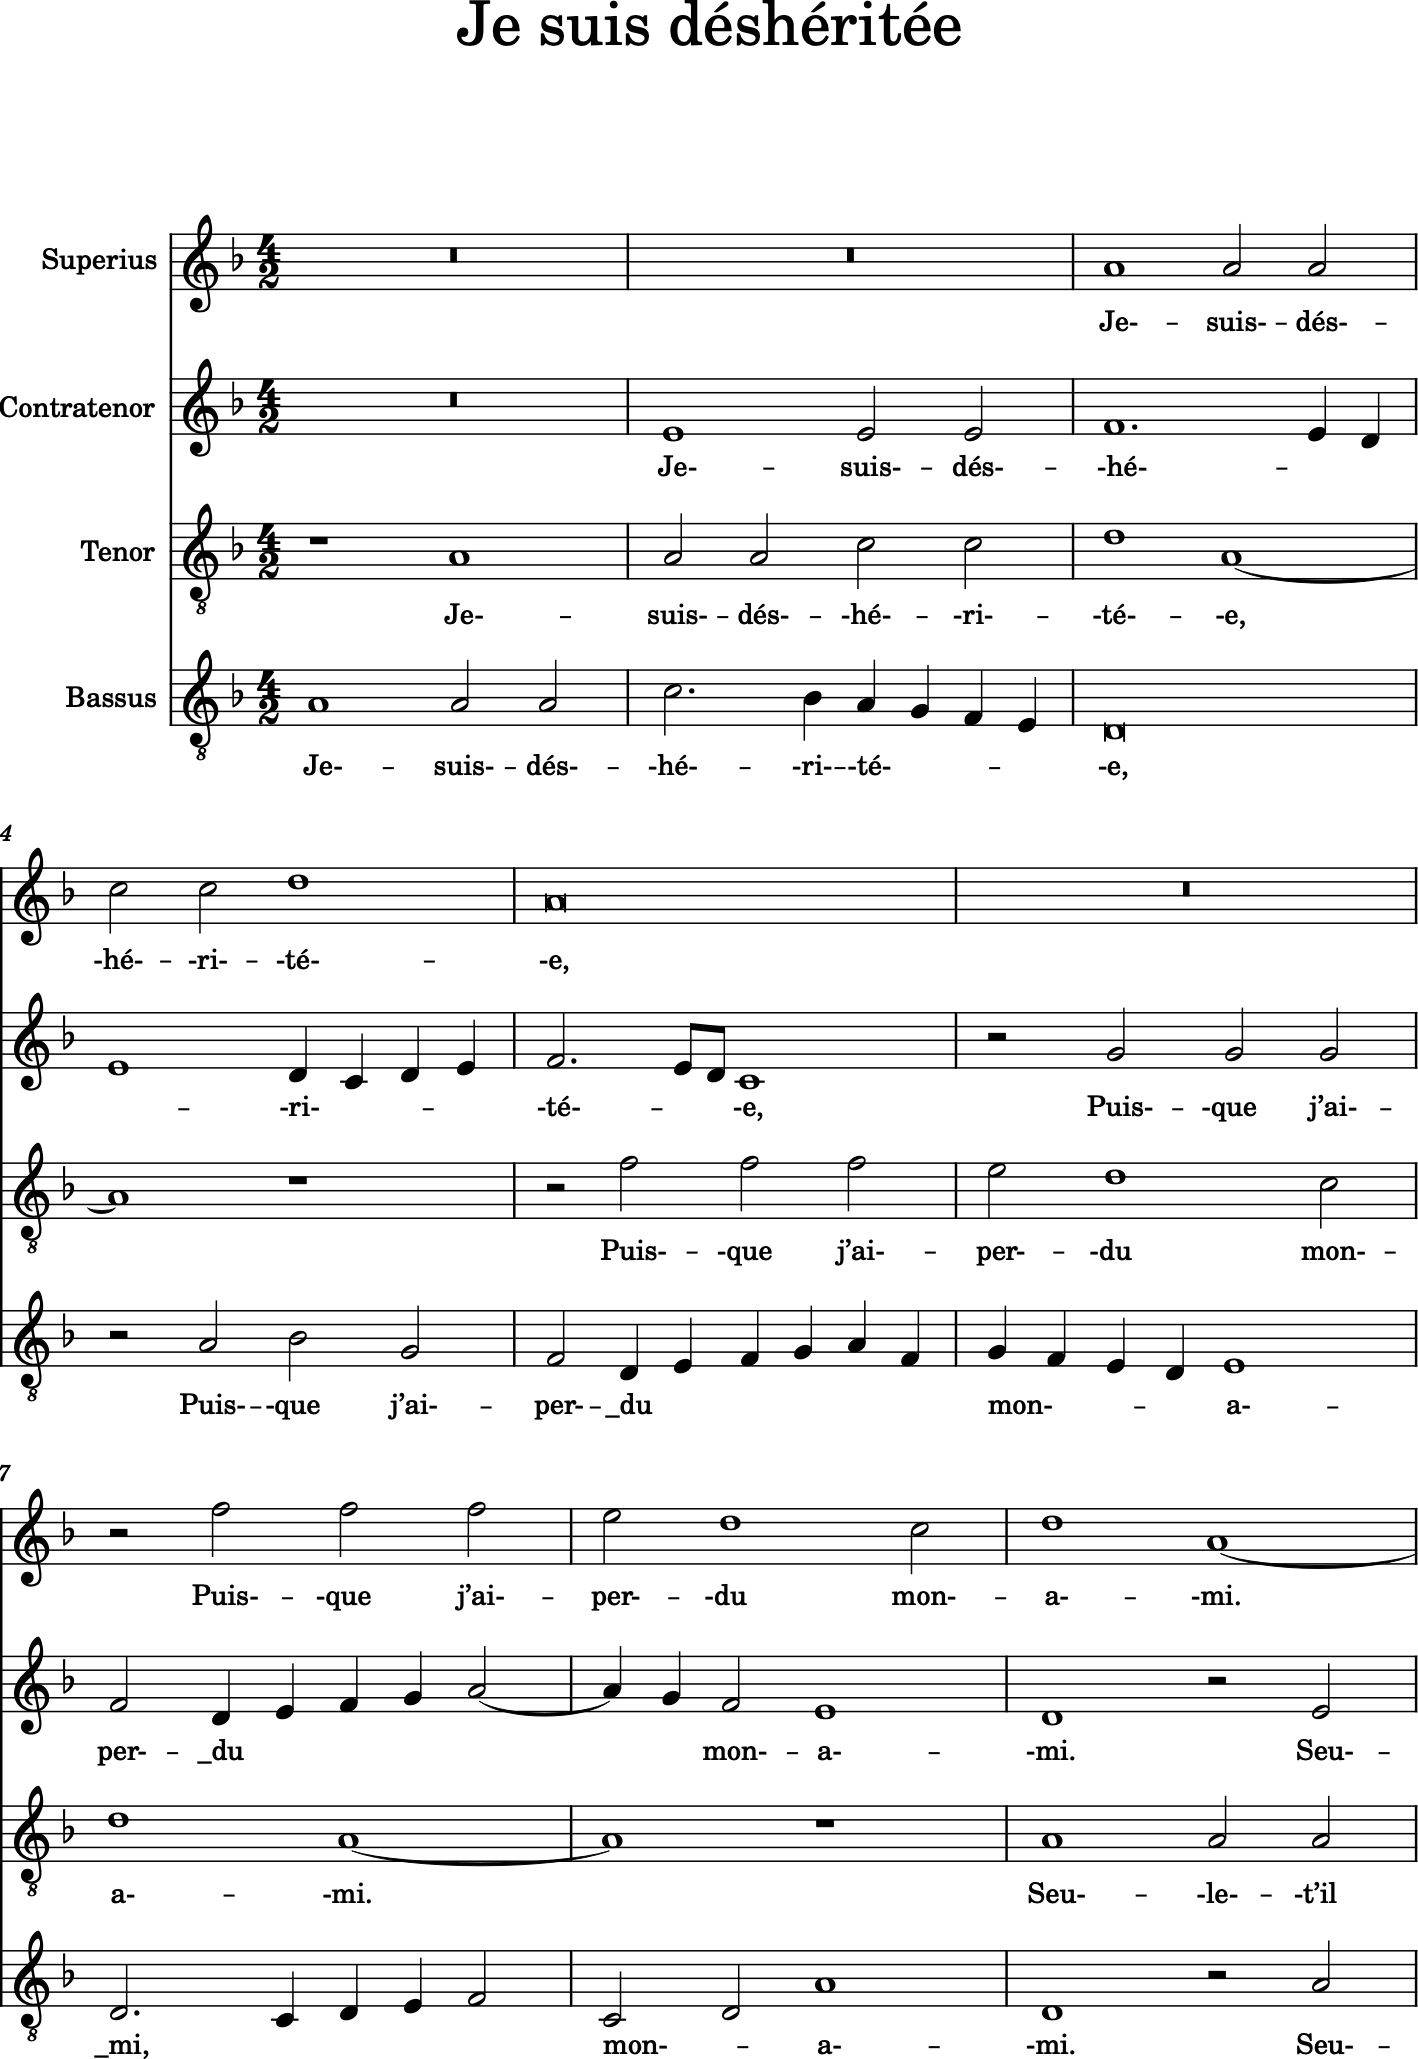

In [7]:
add_offset(model.score)
model.score.measures(1, 30).show()

# Music as a table

In [8]:
model.getNoteRest().head(10).fillna("-").T.style.applymap(map_colours)

,0.0,4.0,6.0,8.0,10.0,11.0,12.0,13.0,14.0,15.0
Superius,Rest,-,-,Rest,-,-,-,-,-,-
Contratenor,Rest,-,-,E4,-,-,E4,-,E4,-
Tenor,Rest,A3,-,A3,A3,-,C4,-,C4,-
Bassus,A3,A3,A3,C4,-,B-3,A3,G3,F3,E3


In [9]:
model.getNoteRest()

,Superius,Contratenor,Tenor,Bassus
0.0,Rest,Rest,Rest,A3
4.0,NaN,NaN,A3,A3
6.0,NaN,NaN,NaN,A3
8.0,Rest,E4,A3,C4
10.0,NaN,NaN,A3,NaN
...,...,...,...,...
241.0,D5,NaN,F4,NaN
242.0,D5,G4,E4,B-3
243.0,NaN,NaN,D4,NaN
244.0,NaN,A4,E4,A3


# Melodic patterns

In [10]:
model_melodic = model.getMelodic(kind="c", unit=2)
model_melodic

,Superius,Contratenor,Tenor,Bassus
0.0,Rest,Rest,Rest,NaN
2.0,Rest,Rest,Rest,0
4.0,Rest,Rest,NaN,0
6.0,Rest,Rest,0,0
8.0,Rest,NaN,0,3
...,...,...,...,...
238.0,-1,3,2,-2
240.0,0,-2,0,-5
242.0,-2,-3,-3,3
244.0,0,2,0,-1


In [11]:
ngrams = model.getNgrams(df=model.getMelodic(kind="d", compound=True), n=5)
ngrams

,Superius,Contratenor,Tenor,Bassus
4.0,NaN,NaN,NaN,"(1, 1, 3, -2, -2)"
6.0,NaN,NaN,NaN,"(1, 3, -2, -2, -2)"
8.0,NaN,NaN,"(1, 1, 3, 1, 2)","(3, -2, -2, -2, -2)"
10.0,NaN,NaN,"(1, 3, 1, 2, -4)",NaN
11.0,NaN,NaN,NaN,"(-2, -2, -2, -2, -2)"
...,...,...,...,...
234.0,"(3, -2, -2, 1, -2)",NaN,NaN,"(3, -2, -4, 3, -2)"
235.0,NaN,"(2, 2, 2, 2, -2)","(2, 2, 2, -2, -2)",NaN
236.0,NaN,"(2, 2, 2, -2, -3)","(2, 2, -2, -2, -2)",NaN
237.0,NaN,"(2, 2, -2, -3, 2)",NaN,NaN


In [12]:
ngrams.stack().to_frame()

0
4.0   Bassus         (1, 1, 3, -2, -2)
6.0   Bassus        (1, 3, -2, -2, -2)
8.0   Tenor            (1, 1, 3, 1, 2)
      Bassus       (3, -2, -2, -2, -2)
10.0  Tenor           (1, 3, 1, 2, -4)
...                                ...
235.0 Tenor          (2, 2, 2, -2, -2)
236.0 Contratenor    (2, 2, 2, -2, -3)
      Tenor         (2, 2, -2, -2, -2)
237.0 Contratenor    (2, 2, -2, -3, 2)
238.0 Tenor         (2, -2, -2, -2, 2)

[220 rows x 1 columns]

## Searching with various parameters
* Note that if 'units' are no specified, then the results are simply the melodic vectors, regardless of duration.
* If we specify "units" then the results are incremental by that unit
* The results will be different in each case
* Sample search: 4, 1, 2, 2 or chromatic 5, 0, 2, 2, -4

In [9]:
# Ngrams without time_units
@interact(search_pattern="", kind=["d", "c"])
def get_ngrams(search_pattern, kind):
    ngrams = model.getNgrams(df=model.getMelodic(kind=kind), n=5)
    mask = ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)
    filtered_ngrams = ngrams[mask].copy()
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='kind', options=('d',…

In [14]:
# NGrams with time_units

@interact(search_pattern="", kind=["d", "c", "z"], time_unit=[1, 2, 4, 8], length=[3, 4, 5, 6, 7])
def get_ngrams(search_pattern, kind, time_unit, length):
    ngrams = model.getNgrams(df=model.getMelodic(kind=kind), n=length, unit=time_unit)
    mask = ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)
    filtered_ngrams = ngrams[mask].copy()
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='kind', options=('d',…

# Count of melodic intervals

In [15]:
model.getMelodic(directed=True).apply(pd.Series.value_counts).fillna(0).astype(int).style.bar()

,Superius,Contratenor,Tenor,Bassus
-M2,11,23,17,23
-M3,1,3,1,3
-P4,5,1,3,3
-P5,0,1,2,5
-m2,9,7,10,7
-m3,0,3,1,5
M2,10,27,15,18
M3,0,2,1,2
P1,19,18,15,15
P4,1,1,2,3


# Harmonic intervals

Example search pattern: 12, 10, 8, 8|5, 3, 1, 1$

Authentic cadence:  7, 6, 8

In [10]:
@interact(search_pattern="", kind=["d", "c"], length=[5, 3, 4, 6, 7])
def get_ngrams(search_pattern, kind, length):
    ngrams = model.getNgrams(df=model.getMelodic(kind=kind), n=length)
    mask = ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)
    filtered_ngrams = ngrams[mask].copy()
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='kind', options=('d',…

In [17]:
har = model.getHarmonic(kind="d")
regHar = model.regularize(df=har, unit=1)
regHar

,Bassus_Tenor,Bassus_Contratenor,Bassus_Superius,Tenor_Contratenor,Tenor_Superius,Contratenor_Superius
0.0,Rest,Rest,Rest,Rest,Rest,Rest
1.0,Rest,Rest,Rest,Rest,Rest,Rest
2.0,Rest,Rest,Rest,Rest,Rest,Rest
3.0,Rest,Rest,Rest,Rest,Rest,Rest
4.0,1,Rest,Rest,Rest,Rest,Rest
...,...,...,...,...,...,...
243.0,3,6,10,4,8,5
244.0,5,8,11,4,7,4
245.0,5,8,11,4,7,4
246.0,5,8,10,4,6,3


In [18]:
mel = model.getNgrams(df=model.getMelodic(kind="d"), n=4)
# regMel = ave_maria.regularize(df=mel, unit=4)
# regMel.stack().to_frame().reset_index(level=1)
b = mel.stack().to_frame().reset_index(level=1)
b.groupby("level_1")

## Return offsets as list
### For use with filtered DFs from classifier, etc.

In [19]:
df = get_harmonic_ngrams("7, 6, 8", True, "d", 1, 3)
a = df.index.tolist()
a

# measures
for i in a:
    b = i/8 - 1
    print(b)
a

3.625
4.5
6.5
11.625
12.5
13.625
14.5
18.5
21.5
25.0


[37.0, 44.0, 60.0, 101.0, 108.0, 117.0, 124.0, 156.0, 180.0, 208.0]

In [27]:
cadence_filter = get_harmonic_ngrams("7, 6, 8", True, "d", 1, 3)
cadence_list = cadence_filter.index.tolist()
cadence_tones = model.getNoteRest()
cadence_tones.loc[cadence_list,:].fillna("-")


,Superius,Contratenor,Tenor,Bassus
37.0,-,-,-,G3
44.0,-,G4,-,E3
60.0,-,E4,Rest,A3
101.0,-,-,-,G3
108.0,-,G4,-,E3
117.0,-,-,G4,-
124.0,-,A4,E4,A3
156.0,F5,G4,C4,-
180.0,-,G4,D4,G3
208.0,B-4,G4,-,G3


# Modules:

* Authentic/Phrygian cadence with suspension in diatonic:  7_Held, 6_-2, 8
* Authentic/Phrygian cadence with suspension in chromatic: 11_Held, 9_-2, 12
* Authentic/Phrygian cadence with suspension in zero-based:  6_Held, 5_-2, 7

* Authentic



In [173]:
@interact(search_pattern="", compound=[True, False], time_unit=[0, 4, 2, 1, 8], length=[3, 4, 5, 6])
def get_modules(search_pattern, compound, time_unit, length):
    
    model_har = model.getHarmonic(kind="d", compound=compound)
#     ngrams = model.getNgrams(df=model_har, n=length, how='modules', exclude=['Rest'], cell_type="str", unit=time_unit)
    ngrams = model.getNgrams(df=model_har, n=length, how='modules', exclude=['Rest'], cell_type="str")

    filtered_ngrams = ngrams[ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)].copy()
    
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if re.match(search_pattern, x) else "")
    

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='compound', options=(…

In [174]:
@interact(search_pattern="", compound=[True, False], time_unit=[0, 4, 2, 1, 8], length=[3, 4, 5, 6])
def get_modules(search_pattern, compound, time_unit, length):
    
    model_har = model.getHarmonic(kind="d", compound=compound)
#     ngrams = model.getNgrams(df=model_har, n=length, how='modules', exclude=['Rest'], cell_type="str", unit=time_unit)
    ngrams = model.getNgrams(df=model_har, n=length, how='modules', exclude=['Rest'], cell_type="str")

    filtered_ngrams = ngrams[ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)].copy()
    
    a = filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if re.match(search_pattern, x) else "")
    c = a.index.to_list()
    return c

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='compound', options=(…

In [177]:
# here we take the offsets of the predicted cadences and find the pitches associated with them
# note that these are the _start_ offsets of the module.  we will need to find the end points for a more accurate tonal map


c = [87.0, 88.0, 111.0, 131.5, 132.0, 167.5, 168.0]
notes = model.getNoteRest()
notes.loc[a]

,Superius,Contratenor,Tenor,Bassus
37.0,NaN,NaN,NaN,G3
44.0,NaN,G4,NaN,E3
60.0,NaN,E4,Rest,A3
101.0,NaN,NaN,NaN,G3
108.0,NaN,G4,NaN,E3
117.0,NaN,NaN,G4,NaN
124.0,NaN,A4,E4,A3
156.0,F5,G4,C4,NaN
180.0,NaN,G4,D4,G3
208.0,B-4,G4,None,G3


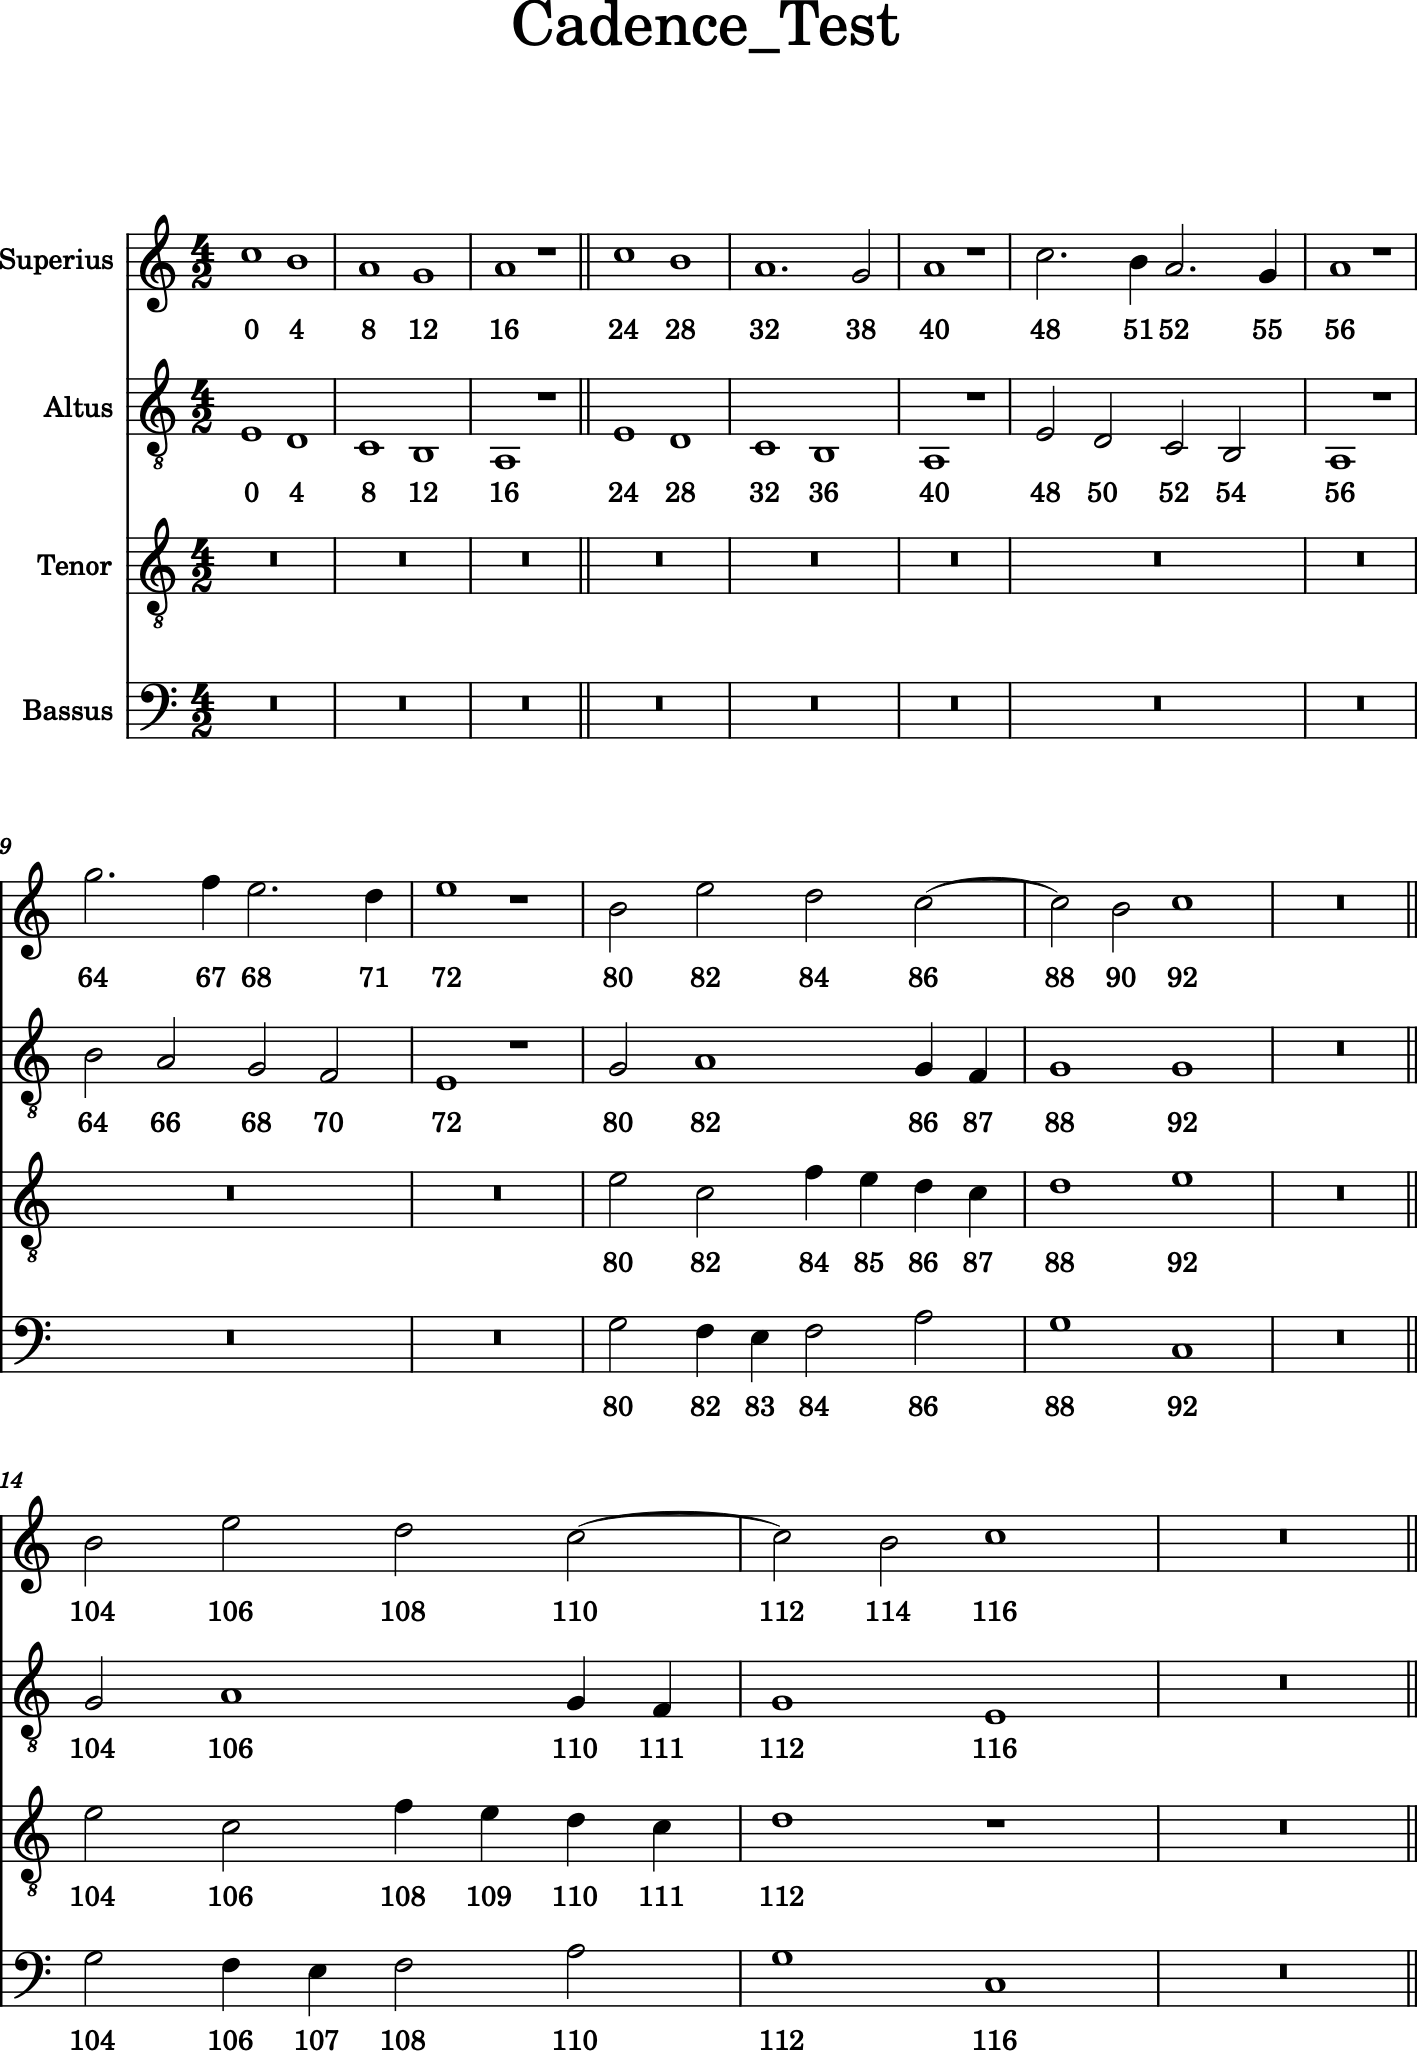

In [27]:
model.score.measures(1, 30).show()

In [29]:
a

NameError: name 'a' is not defined

In [35]:
model_har = model.getHarmonic(kind="d", compound=True)
ngrams = model.getNgrams(df=model_har, n=3, how='modules', exclude=['Rest'], cell_type="str")
# filtered_ngrams = ngrams[ngrams.apply(lambda x: x.astype(str).str.contains('7').any(), axis=1)].copy()
# filtered_ngrams.stack().value_counts().to_frame()
ngrams.stack().value_counts().to_frame()

,0
"3_Held, 2_Held, 3",8
"6_-2, 7_-2, 8",8
"4_Held, 3_Held, 2",7
"5_-2, 6_-2, 7",7
"5_Held, 4_Held, 3",7
...,...
"5_2, 6_3, 3",1
"8_2, 6_2, 5",1
"-2_Held, -3_Held, 1",1
"6_Held, 5_2, 3",1
